# Covid Impact Survey Analysis

</br>
<div>
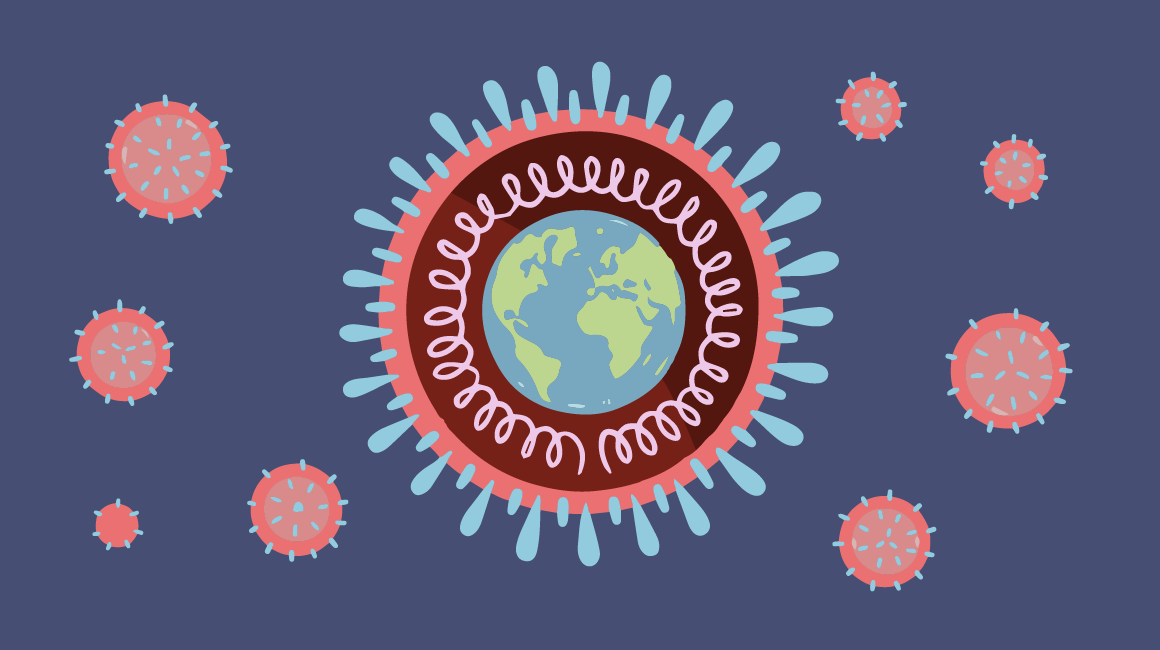
</div>

This notebook performs some analysis of COVID Impact Survey, which provides statistics about physical health, mental health, economic security and social dynamics related to the coronavirus pandemic in the United States. The data has been obtained from <a href="https://data.world/associatedpress/covid-impact-survey-public-data">here</a>.

Conducted by NORC at the University of Chicago for the Data Foundation, the probability-based survey provides estimates for the United States as a whole, as well as in 10 states (California, Colorado, Florida, Louisiana, Minnesota, Missouri, Montana, New York, Oregon and Texas) and eight metropolitan areas (Atlanta, Baltimore, Birmingham, Chicago, Cleveland, Columbus, Phoenix and Pittsburgh).

The survey is designed to allow for an ongoing gauge of public perception, health and economic status to see what is shifting during the pandemic. When multiple sets of data are available, it will allow for the tracking of how issues ranging from COVID-19 symptoms to economic status change over time.

As it is a survey data, all the analysis has been properly done based on the weight given in the data source.

# Business question
* How is the state of people’s mental health after Covid strikes?
* On the economic aspect, how are the people who got furloughed getting help?
* How many people are taking various precautions for Covid?

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

% matplotlib inline
pd.options.display.html.use_mathjax = False
pd.options.display.max_columns = 100
sns.set_style('darkgrid')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def save_plot(directory:str, filename:str):
    """
    Save the image in the matplotlib context in the directory with the specified filename
    the directory will be created if it does not exist
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(os.path.join(directory,filename), bbox_inches='tight')
    
def get_data():
    """
    Load the data set and print the shape
    """ 
    
    covid_filepath = "associatedpress-covid-impact-survey-public-data"
    april_survey_data_path = os.path.join(covid_filepath,"data", "01_april_30_covid_impact_survey.csv")
    may_survey_data_path = os.path.join(covid_filepath,"data", "02_may_12_covid_impact_survey.csv")
    june_survey_data_path = os.path.join(covid_filepath,"data", "03_june_9_covid_impact_survey.csv")

    df_survey = pd.DataFrame()
    df_survey_april = pd.read_csv(april_survey_data_path)
    
    # take only p_panel=Amerispeak 
    df_survey_april = df_survey_april.loc[df_survey_april['p_panel'] == 'Amerispeak'].copy()
    df_survey_april['week'] = 1
    print(f"Shape of the data set - April: {df_survey_april.shape}")

    df_survey_may = pd.read_csv(may_survey_data_path)
    df_survey_may = df_survey_may.loc[df_survey_may['p_panel'] == 'Amerispeak'].copy()
    df_survey_may['week'] = 2
    print(f"Shape of the data set - May: {df_survey_may.shape}")

    df_survey_june = pd.read_csv(june_survey_data_path)
    df_survey_june = df_survey_june.loc[df_survey_june['p_panel'] == 'Amerispeak'].copy()
    df_survey_june['week'] = 3
    print(f"Shape of the data set - June: {df_survey_june.shape}")
    return df_survey_april, df_survey_may, df_survey_june

In [3]:
df_survey_april, df_survey_may, df_survey_june = get_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (96,156,168,170) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Shape of the data set - April: (2190, 175)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (172) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Shape of the data set - May: (2238, 179)
Shape of the data set - June: (2047, 179)


In [4]:
# the survey result in April has less columns, we can check the difference
print("Columns in the result in May that are not in April")
set(df_survey_may.columns) - set(df_survey_april.columns)

Columns in the result in May that are not in April


{'lgbt', 'marital', 'nat_wgt_comb_pop', 'reg_wgt_comb_pop'}

In [5]:
# as we want to combine the 3 survey results, we can use the smallest common subset of the columns
df_survey_may = df_survey_may[df_survey_april.columns].copy()
df_survey_june = df_survey_june[df_survey_april.columns].copy()
df_survey = pd.concat([df_survey_april,df_survey_may, df_survey_june])
df_survey = df_survey.drop(['p_panel','column_a'], axis=1)
df_survey.shape

(6475, 173)

## Filtering the columns
The data set has a rich set of questions. However in this analysis we will focus on answering the business questions that have been defined before. Therefore, we will use only a subset of the columns. For the sake of readability, I rename the columns.

In [6]:
dict_rename_mental_health = {
    'soc5a': 'mh_anxious',
    'soc5b': 'mh_depressed',
    'soc5c': 'mh_lonely',
    'soc5d': 'mh_hopeless',
    'soc5e': 'mh_panic_attack'
}
dict_rename_employment = {
    'econ1': 'emp_work_7days', #In the past 7 days, did you do any work for pay at a job or business?
    'econ2': 'emp_work_hours_7days', #How many hours did you work last week at all jobs?
    'econ3': 'emp_pre_covid_hours', #Prior to March 1, 2020 when COVID-19 began spreading in the United States, how many hours did you usually work each week?
    'econ4': 'emp_no_work_reason', #What was your main reason for not working for pay?
    'econ4a': 'emp_work_future30D', #Think about 30 days from now, how likely do you think it is that you will be employed at that time?
    'econ4b': 'emp_work_future3M'#Think about 3 months from now, how likely do you think it is that you will be employed at that time?
}

# In the past 7 days, have you either received, applied for, or tried to apply for any of the following forms of income or assistance, or not?
dict_rename_aid = {
    'econ6a': 'a_unemployment_insurance', #[Unemployment insurance] 
    'econ6b': 'a_nutrition_assist', #[SNAP (Supplemental Nutrition Assistance Program)]
    'econ6c': 'a_tanf', #[TANF (Temporary Assistance for Needy Families)]
    'econ6d': 'a_soc_sec', #[Social Security]
    'econ6e': 'a_supp_soc_sec', #[Supplemental Social Security]
    'econ6f': 'a_gov_health_insurance', # [Any kind of government health insurance or health coverage plan including Medicaid, Medical Assistance or Medicare]
    'econ6g': 'a_other_gov', #[Other aid from the government]
    'econ6h': 'a_union', #[Assistance from a union or other association]
    'econ6i': 'a_church', #[Assistance from a church or religious organization]
    'econ6j': 'a_comm', #[Assistance from another community organization]
    'econ6k': 'a_pantry_7', #[A food pantry]
    'econ6l': 'a_other_7' #[Other assistance]
}
# Which of the following measures, if any, are you taking in response to the coronavirus?
dict_rename_precaution = {
    'phys2_1': 'prec_canceled_doctor_app', # [Canceled a doctor appointment]
    'phys2_2': 'prec_mask', # [Worn a face mask] 
    'phys2_3': 'prec_visit_doct', # [Visited a doctor or hospital] 
    'phys2_4': 'prec_x_work', # [Canceled or postponed work activities] 
    'phys2_5': 'prec_x_school', # [Canceled or postponed school activities] 
    'phys2_6': 'prec_x_dentist', # [Canceled or postponed dentist or other appointment] 
    'phys2_7': 'prec_x_housekeeper', # [Canceled outside housekeepers or caregivers] 
    'phys2_8': 'prec_avoid_restaurants', # [Avoided some or all restaurants]
    'phys2_9': 'prec_telework', # [Worked from home] 
    'phys2_10': 'prec_telestudy', # [Studied from home] 
    'phys2_11': 'prec_x_recre_act', # [Canceled or postponed pleasure, social, or recreational activites] 
    'phys2_12': 'prec_stockpiled', # [Stockpiled food or water] 
    'phys2_13': 'prec_avoid_crowd', # [Avoided public or crowded places] 
    'phys2_14': 'prec_prayed', # [Prayed] 
    'phys2_15': 'prec_avoid_high_risk', # [Avoided contact with high-risk people] 
    'phys2_16': 'prec_wash_hands', # [Washed or sanitized hands] 
    'phys2_17': 'prec_six_feet', # [Kept six feet distance from those outside my household] 
    'phys2_18': 'prec_stay_home', # [Stayed home because I felt unwell] 
    'phys2_19': 'prec_wipe_packages'# [Wiped packages entering my home] 
}

# Please indicate whether the following statements were often true, sometimes true, or never true for you or your household over the past 30 days.
dict_rename_food = {
    'econ5a_a': 'food_run_out', #[We worried our food would run out before we got money to buy more] 
    'econ5a_b': 'food_didnt_last' # [The food that we bought just didn't last, and we didn't have money to get more]
}

cols_demographic = ['age7', 'gender', 'hhincome', 'education','hhsize1','su_id']
cols_stats = ['national_weight','week']
cols_weight = ['national_weight']

cols = {**dict_rename_mental_health,
        **dict_rename_employment,
        **dict_rename_aid,
        **dict_rename_precaution,
        **dict_rename_food}

l_cols = list(cols.keys())
l_cols.extend(cols_demographic)
l_cols.extend(cols_stats)
l_cols.append('p_geo')

df = df_survey[l_cols].copy()
df.rename(cols, axis=1, inplace=True)

In [7]:
# some variables for visualization purpose, will be used later
map_title_demographic = {
    'age7': 'age',
    'gender': 'gender',
    'hhincome': 'household income',
    'education': 'education level',
    'hhsize1': 'household size'
}
hue_order = {'hhincome' : ['<10K',
                       '10K-20K',
                       '20K-30K',
                       '30K-40K',
                       '40K-50K',
                       '50K-75K',
                       '75K-100K', 
                       '100K-150K',  
                       '>150K'],
              'gender' : ['(1) Male', '(2) Female'],
              'age7': ['(1) 18-24', 
                           '(2) 25-34', 
                           '(3) 35-44', 
                           '(4) 45-54', 
                           '(5) 55-64',
                           '(6) 65-74', 
                           '(7) 75+'],
              'hhsize1':['(1) One person, I live by myself', 
                         '(2) Two persons',
                         '(3) Three persons', 
                         '(4) Four persons',
                         '(5) Five persons',
                         '(6) Six or more persons'],
              'education':['(1) No HS diploma',
                           '(2) HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)',
                           '(3) Some college, no degree', 
                           '(4) Associate degree',
                           '(5) Bachelors degree', 
                           '(6) Masters degree',
                           '(7) Professional or Doctorate degree']
        }

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6475 entries, 6600 to 7504
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mh_anxious                6475 non-null   object 
 1   mh_depressed              6475 non-null   object 
 2   mh_lonely                 6475 non-null   object 
 3   mh_hopeless               6475 non-null   object 
 4   mh_panic_attack           6475 non-null   object 
 5   emp_work_7days            6475 non-null   object 
 6   emp_work_hours_7days      2769 non-null   object 
 7   emp_pre_covid_hours       6475 non-null   object 
 8   emp_no_work_reason        3206 non-null   object 
 9   emp_work_future30D        6475 non-null   object 
 10  emp_work_future3M         6475 non-null   object 
 11  a_unemployment_insurance  6475 non-null   object 
 12  a_nutrition_assist        6475 non-null   object 
 13  a_tanf                    6475 non-null   object 
 14  a_soc

In [9]:
df.describe(include='all')

,mh_anxious,mh_depressed,mh_lonely,mh_hopeless,mh_panic_attack,emp_work_7days,emp_work_hours_7days,emp_pre_covid_hours,emp_no_work_reason,emp_work_future30D,emp_work_future3M,a_unemployment_insurance,a_nutrition_assist,a_tanf,a_soc_sec,a_supp_soc_sec,a_gov_health_insurance,a_other_gov,a_union,a_church,a_comm,a_pantry_7,a_other_7,prec_canceled_doctor_app,prec_mask,prec_visit_doct,prec_x_work,prec_x_school,prec_x_dentist,prec_x_housekeeper,prec_avoid_restaurants,prec_telework,prec_telestudy,prec_x_recre_act,prec_stockpiled,prec_avoid_crowd,prec_prayed,prec_avoid_high_risk,prec_wash_hands,prec_six_feet,prec_stay_home,prec_wipe_packages,food_run_out,food_didnt_last,age7,gender,hhincome,education,hhsize1,su_id,national_weight,week,p_geo
count,6475,6475,6475,6475,6475,6475,2769,6475,3206,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6475,6.475000e+03,6475.000000,6475.000000,2176
unique,6,6,7,7,7,6,127,85,14,8,8,6,6,7,7,7,7,7,7,7,7,7,7,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,6,5,7,2,9,7,6,NaN,NaN,NaN,8
top,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,"(3) No, I did not work for pay last week.",40,40,(2) I am retired,(1) Extremely likely,(1) Extremely likely,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(0) No,(1) Yes,(0) No,(0) No,(0) No,(0) No,(0) No,(1) Yes,(0) No,(0) No,(1) Yes,(0) No,(1) Yes,(1) Yes,(1) Yes,(1) Yes,(1) Yes,(0) No,(0) No,(3) Never true,(3) Never true,(2) 25-34,(2) Female,"$50,000 to under $75,000","(3) Some college, no degree","(1) One person, I live by myself",NaN,NaN,NaN,California
freq,3943,3913,3946,3881,5782,3206,1064,1855,1571,2211,2214,5505,5396,6195,4839,6000,4847,5506,6252,6218,6225,5866,6159,4411,5383,5862,4591,5243,4054,5885,4598,4319,5556,4359,4273,5028,3439,3907,5908,5520,5777,3743,4838,5195,1437,3321,1267,1801,1991,NaN,NaN,NaN,818
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000619e+07,1.000000,1.977915,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.107745e+03,0.997969,0.808688,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+07,0.005905,1.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000355e+07,0.355187,1.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000716e+07,0.716055,2.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000834e+07,1.306136,3.000000,NaN


In [10]:
df.isna().sum()*100/df.shape[0]

mh_anxious                   0.000000
mh_depressed                 0.000000
mh_lonely                    0.000000
mh_hopeless                  0.000000
mh_panic_attack              0.000000
emp_work_7days               0.000000
emp_work_hours_7days        57.235521
emp_pre_covid_hours          0.000000
emp_no_work_reason          50.486486
emp_work_future30D           0.000000
emp_work_future3M            0.000000
a_unemployment_insurance     0.000000
a_nutrition_assist           0.000000
a_tanf                       0.000000
a_soc_sec                    0.000000
a_supp_soc_sec               0.000000
a_gov_health_insurance       0.000000
a_other_gov                  0.000000
a_union                      0.000000
a_church                     0.000000
a_comm                       0.000000
a_pantry_7                   0.000000
a_other_7                    0.000000
prec_canceled_doctor_app     0.000000
prec_mask                    0.000000
prec_visit_doct              0.000000
prec_x_work 

As expected, all the variables are categorical. Most of the columns have no missing values. 
As the questions don't seem to need those columns, let's leave them for the moment. 

In [11]:
# cleaning the data as $$ is rendered into mathematical latex formula
transform_hhincome = {'Under $10,000': '<10K',
                       '$10,000 to under $20,000': '10K-20K',
                       '$20,000 to under $30,000': '20K-30K',
                       '$30,000 to under $40,000': '30K-40K',
                       '$40,000 to under $50,000': '40K-50K',
                       '$50,000 to under $75,000': '50K-75K', 
                       '$75,000 to under $100,000': '75K-100K', 
                       '$100,000 to under $150,000': '100K-150K',
                       '$150,000 or more': '>150K'}
df['hhincome'] = df['hhincome'].map(transform_hhincome)
df.head()

,mh_anxious,mh_depressed,mh_lonely,mh_hopeless,mh_panic_attack,emp_work_7days,emp_work_hours_7days,emp_pre_covid_hours,emp_no_work_reason,emp_work_future30D,emp_work_future3M,a_unemployment_insurance,a_nutrition_assist,a_tanf,a_soc_sec,a_supp_soc_sec,a_gov_health_insurance,a_other_gov,a_union,a_church,a_comm,a_pantry_7,a_other_7,prec_canceled_doctor_app,prec_mask,prec_visit_doct,prec_x_work,prec_x_school,prec_x_dentist,prec_x_housekeeper,prec_avoid_restaurants,prec_telework,prec_telestudy,prec_x_recre_act,prec_stockpiled,prec_avoid_crowd,prec_prayed,prec_avoid_high_risk,prec_wash_hands,prec_six_feet,prec_stay_home,prec_wipe_packages,food_run_out,food_didnt_last,age7,gender,hhincome,education,hhsize1,su_id,national_weight,week,p_geo
6600,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,"(1) Yes, I worked for someone else for wages, ...",40,40,NaN,(1) Extremely likely,(1) Extremely likely,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(0) No,(1) Yes,(0) No,(0) No,(0) No,(1) Yes,(0) No,(1) Yes,(1) Yes,(0) No,(0) No,(0) No,(1) Yes,(1) Yes,(0) No,(1) Yes,(1) Yes,(0) No,(0) No,(3) Never true,(3) Never true,(5) 55-64,(2) Female,75K-100K,(6) Masters degree,"(1) One person, I live by myself",40000001,0.302811,1,NaN
6601,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,"(1) Yes, I worked for someone else for wages, ...",40,40,NaN,(1) Extremely likely,(1) Extremely likely,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(0) No,(0) No,(0) No,(0) No,(0) No,(0) No,(0) No,(1) Yes,(0) No,(1) Yes,(0) No,(1) Yes,(0) No,(1) Yes,(0) No,(0) No,(1) Yes,(0) No,(0) No,(3) Never true,(2) Sometimes true,(3) 35-44,(1) Male,30K-40K,(2) HIGH SCHOOL GRADUATE - high school DIPLOMA...,(5) Five persons,40000005,1.780535,1,NaN
6602,(2) 1-2 days,(1) Not at all or less than 1 day,(2) 1-2 days,(1) Not at all or less than 1 day,(1) Not at all or less than 1 day,"(1) Yes, I worked for someone else for wages, ...",45,45,NaN,(1) Extremely likely,(1) Extremely likely,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(4) Did not receive nor apply for any,(0) No,(1) Yes,(0) No,(1) Yes,(0) No,(1) Yes,(1) Yes,(1) Yes,(1) Yes,(0) No,(1) Yes,(0) No,(1) Yes,(1) Yes,(1) Yes,(1) Yes,(1) Yes,(0) No,(0) No,(3) Never true,(3) Never true,(4) 45-54,(2) Female,100K-150K,(6) Masters degree,(2) Two persons,40000022,0.668195,1,Texas
6603,(2) 1-2 days,(2) 1-2 days,(1) Not at all or less than 1 day,(2) 1-2 days,(1) Not at all or less than 1 day,"(3) No, I did not work for pay last week.",NaN,0,(2) I am retired,(4) Not too likely,(4) Not too likely,(4) Did not receive nor apply for any,(4) 

In [12]:
df_total_national_weight = df.groupby('week')['national_weight'].sum().reset_index().rename({'national_weight':'total_national_weight'}, axis=1)
df_total_national_weight

,week,total_national_weight
0,1,2190.0
1,2,2238.0
2,3,2047.0


# Mental Health

In [13]:
# prepare some variables for visualization

map_title_mental_health = {
    'mh_anxious':'In the past 7 days, how often have you felt \nnervous, anxious, or on edge?',
    'mh_depressed': 'In the past 7 days, how often have you felt \ndepressed?',
    'mh_lonely': 'In the past 7 days, how often have you felt \nlonely?',
    'mh_hopeless': 'In the past 7 days, how often have you felt \nhopeless about the future?',
    'mh_panic_attack': 'In the past 7 days, how often have you had \nphysical reactions such as sweating, '
    'trouble breathing, \nnausea or a pounding heart when thinking about \nyour experience with the coronavirus pandemic?'
}
map_label_mental_health = {
    'mh_anxious':'Anxious',
    'mh_depressed': 'Depressed',
    'mh_lonely': 'Lonely',
    'mh_hopeless': 'Hopeless',
    'mh_panic_attack': 'Panic attack'
}

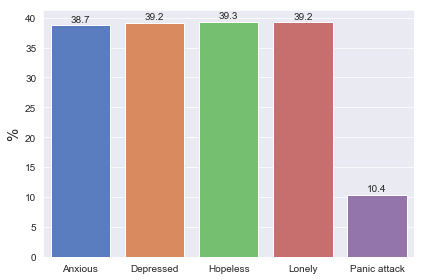

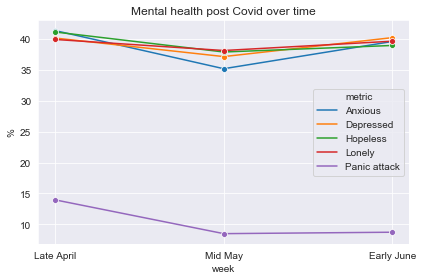

In [14]:
# get all the columns for mental health symptoms
cols_mental_health = list(df.filter(regex='^mh_').columns)

# let's try to calculate the percentage of people having some mental health symptom at least 1 day a week, exclude all the rest
mh_value_to_exclude = ['(1) Not at all or less than 1 day','(98) SKIPPED ON WEB',"(77) DON'T KNOW", '(99) REFUSED']

df_temp = df[cols_mental_health + cols_weight + ['su_id','week']]
df_mh_summarized = df_temp.set_index(['su_id','week', 'national_weight'])\
                          .stack()\
                          .reset_index()\
                          .rename({'level_3':'variable',0:'value'},axis=1)

df_mh_summarized = df_mh_summarized.groupby(['week','variable','value'])\
                                         .agg({'national_weight':'sum'})\
                                         .reset_index()
df_mh_summarized = pd.merge(df_mh_summarized, df_total_national_weight, how='left', left_on='week',right_on='week')
df_mh_summarized['percentage'] = 100*df_mh_summarized['national_weight']/df_mh_summarized['total_national_weight']

df_mh_summarized = df_mh_summarized.rename({'variable':'metric'}, axis=1)
df_mh_summarized['metric'] = df_mh_summarized['metric'].map(map_label_mental_health)
df_mh_summarized = df_mh_summarized.loc[~df_mh_summarized['value'].isin(mh_value_to_exclude)]
df_mh_summarized = df_mh_summarized.groupby(['metric','week'])['percentage'].sum().reset_index()

# shows the percentage of people per mental health symptom
g = sns.barplot(data=df_mh_summarized, 
                x='metric', 
                y='percentage', 
                palette='muted',
                ci=None)

for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()+0.3), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4), 
                   textcoords = 'offset points')

g.set_ylabel('%', fontsize=15) 
g.set_xlabel('', fontsize=15) 
plt.tight_layout()
save_plot('mental_health', 'overview.png')
plt.show()

# shows the change over time
g = sns.lineplot(x='week', y="percentage", hue="metric",marker='o',
                data=df_mh_summarized)
g.set_xticks(range(1,4))

g.set(title='Mental health post Covid over time', xticklabels=['Late April', 'Mid May', 'Early June'], ylabel='%')
plt.tight_layout()
save_plot('mental_health', 'overview_history.jpg')
plt.show()

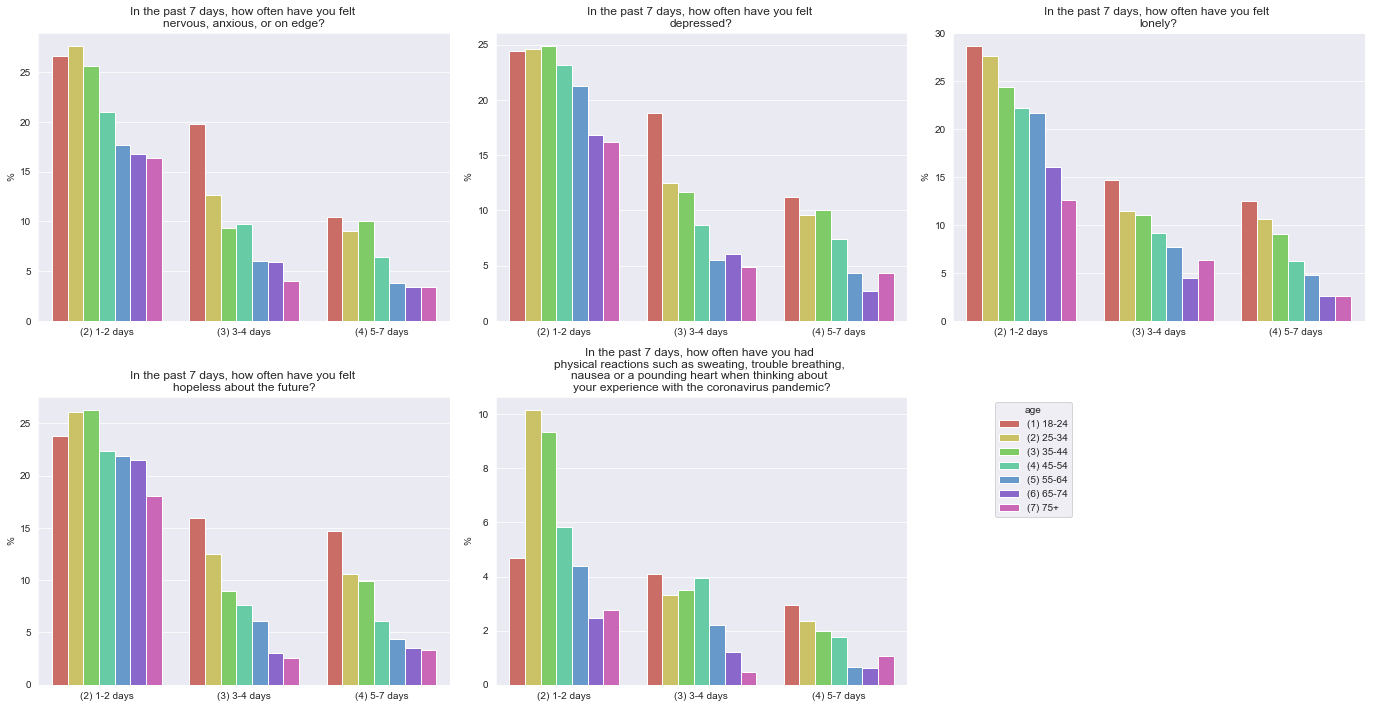

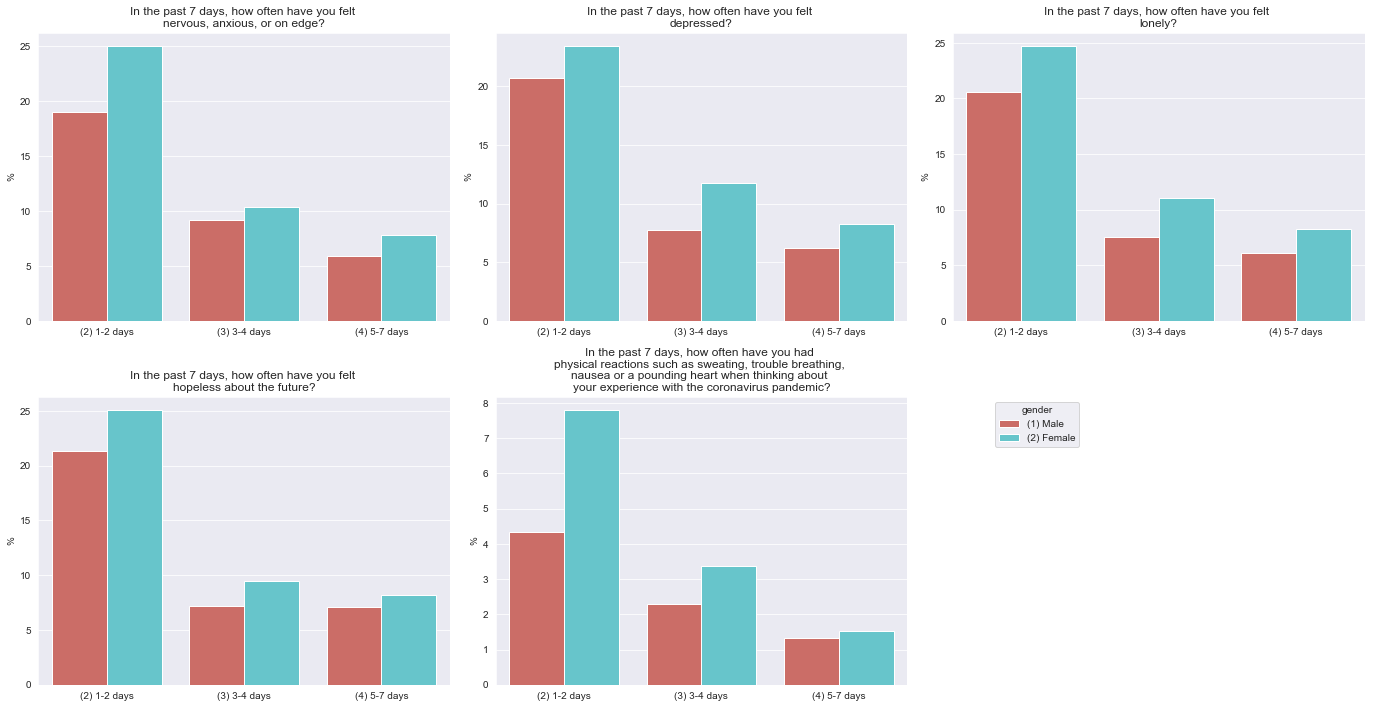

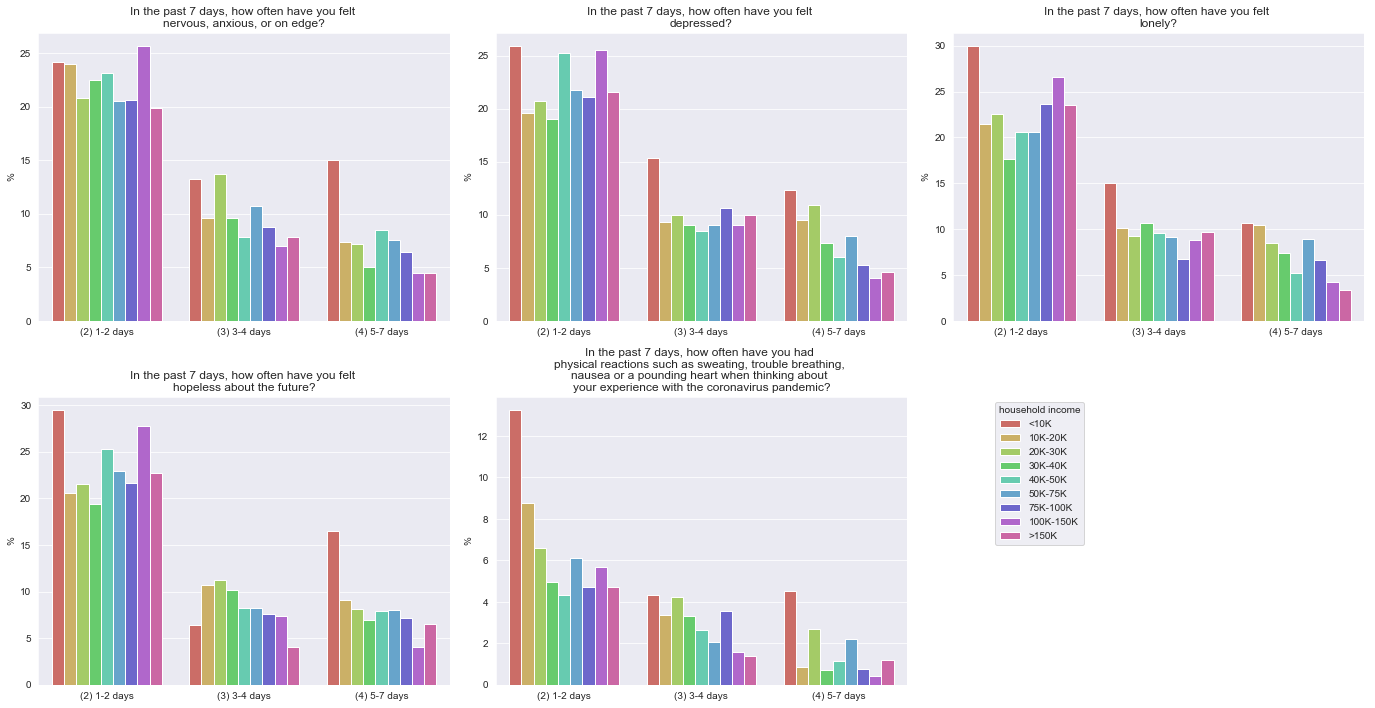

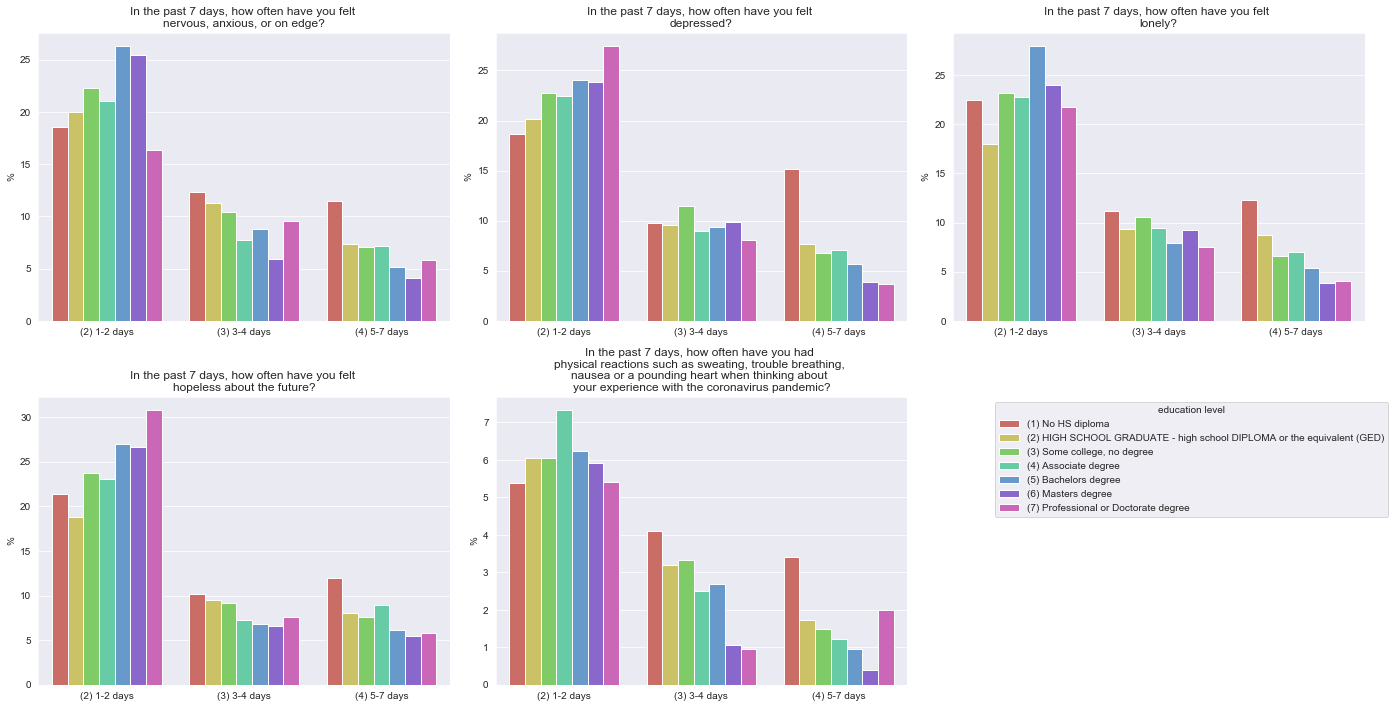

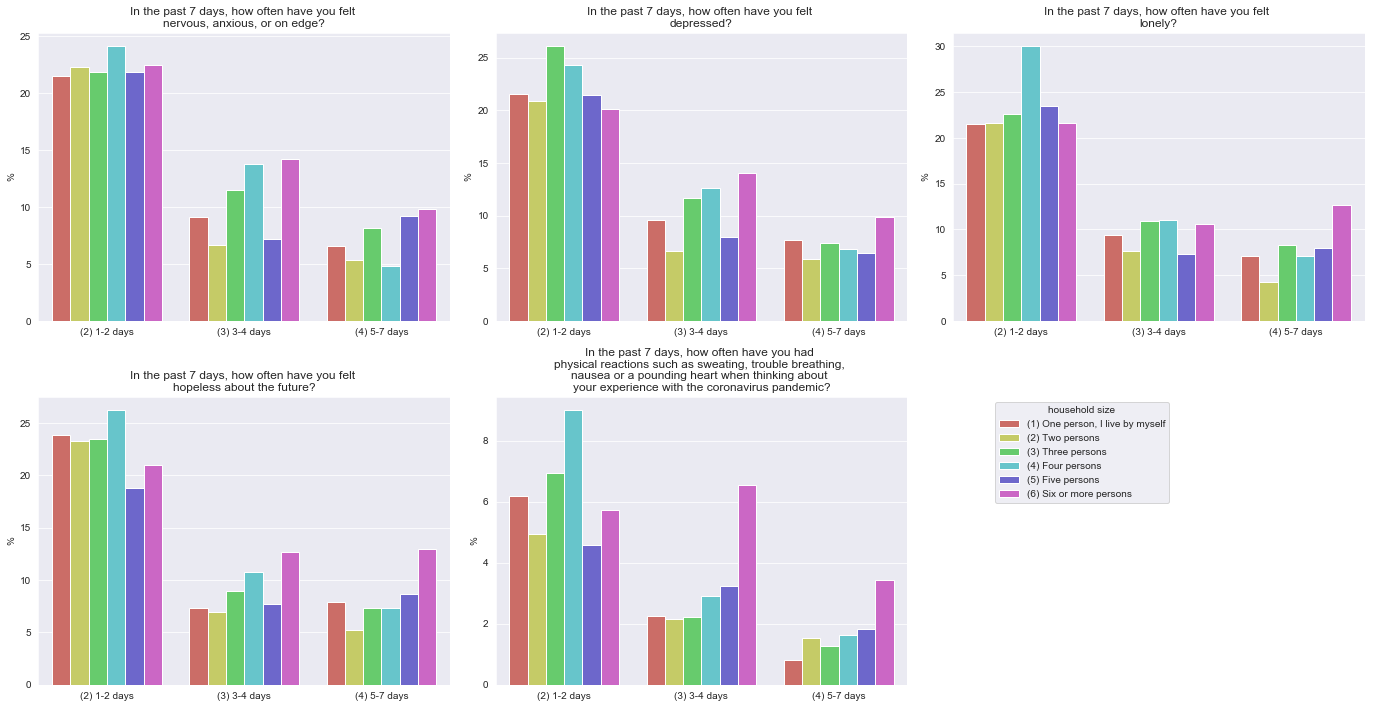

In [15]:
# calculate the distribution by demographic
for demo in cols_demographic:
    if demo == 'su_id':
        continue
    
    fig = plt.figure(figsize=(19.20,10.80))
    
    df_demo = df.groupby([demo,'week'])['national_weight'].sum().reset_index()
    df_demo = df_demo.rename({'national_weight':'total_national_weight'}, axis=1)

    for index, col in enumerate(cols_mental_health):

        df_temp = df.loc[~df[col].isin(mh_value_to_exclude)]
        df_temp = df_temp.groupby(['week',demo,col])['national_weight'].sum().reset_index()
        df_temp = pd.merge(df_temp, df_demo, how='left', left_on=[demo,'week'], right_on=[demo,'week'])
        df_temp['percentage'] = df_temp['national_weight'] * 100 / df_temp['total_national_weight']
        df_temp = df_temp.groupby([demo,'week',col])['percentage'].sum().groupby([demo,col]).mean().reset_index()

        fig1 = fig.add_subplot(2,3,index+1)
        g = sns.barplot(data=df_temp, x=col, y='percentage', hue=demo, hue_order=hue_order[demo], palette='hls')
        g.set(title=map_title_mental_health[col], ylabel='%', xlabel='')
        plt.legend([],[], frameon=False)
        
    plt.subplots_adjust(hspace=0.4,wspace=0.2)
    plt.legend(title=map_title_demographic[demo], bbox_to_anchor=(1.2, 1), loc='upper left')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_plot('mental_health',f'{demo}.jpeg')
    plt.show()

# Employment

In [22]:
# in this section, let's focus on the people who got furloughed
df_furloughed = df.loc[df['emp_no_work_reason'] == '(3) I was laid-off temporarily or furloughed']

df_nat_furloughed = df_furloughed.groupby(['week'])['national_weight'].sum().reset_index()
df_nat_furloughed = df_nat_furloughed.rename({'national_weight':'total_national_weight'}, axis=1)

In [23]:
# calculate the percentage
df_furloughed_ratio = df_furloughed.groupby('week')['national_weight'].sum().to_frame().join(df_total_national_weight.set_index('week'))
df_furloughed_ratio['ratio'] = df_furloughed_ratio['national_weight']/df_furloughed_ratio['total_national_weight']
df_furloughed_ratio['ratio'].mean() * 100

8.972591645013528

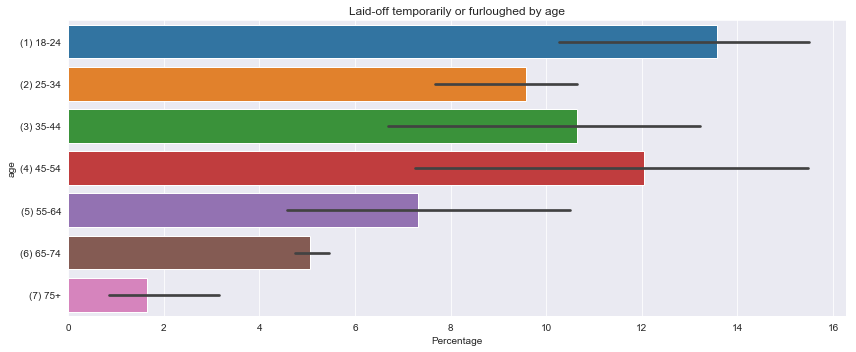

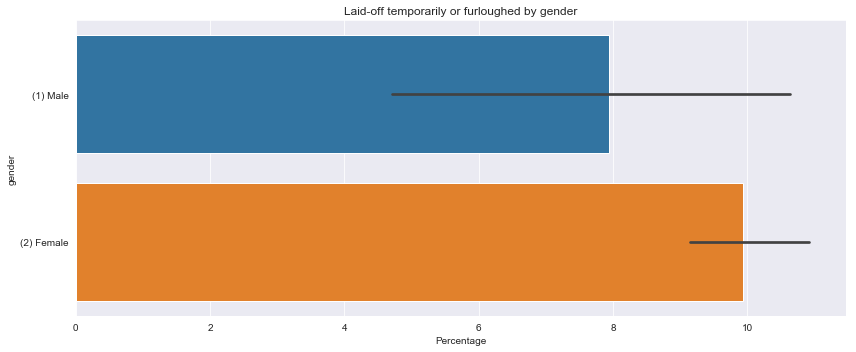

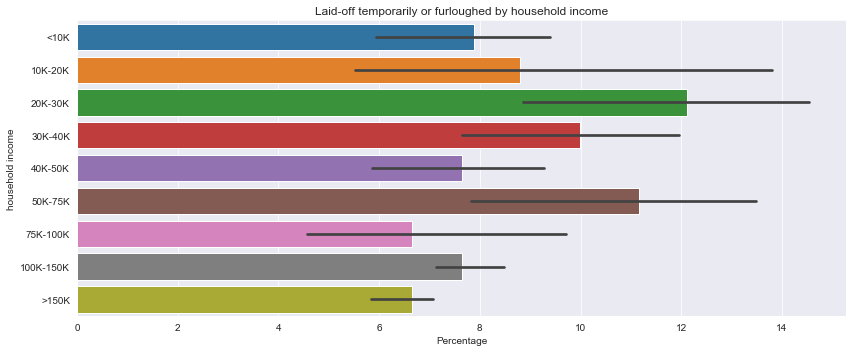

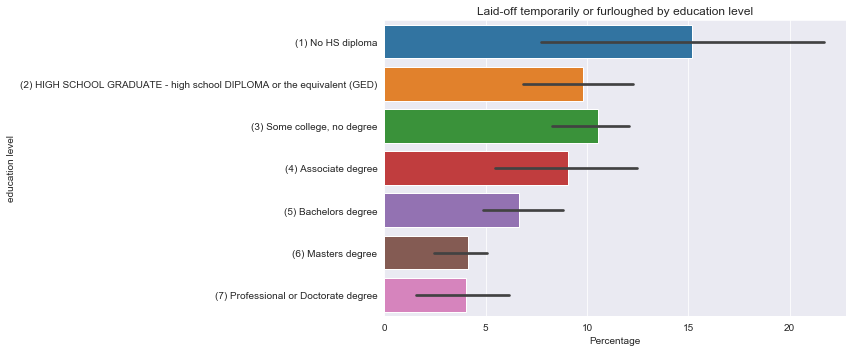

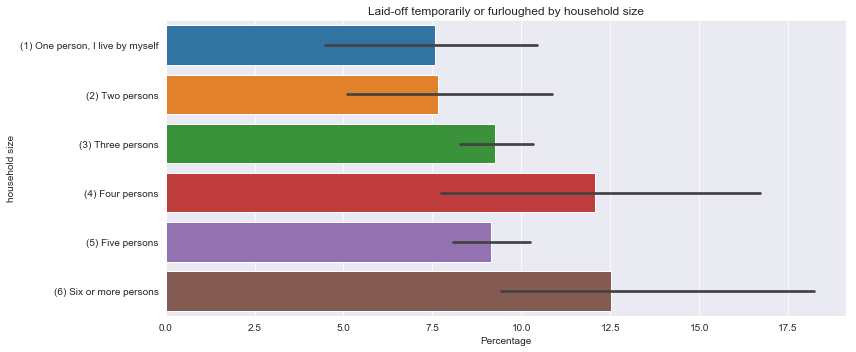

In [24]:
# shows the percentage by demographic
cols_employment = list(df.filter(regex='^emp_').columns)

for demo in cols_demographic:
    if demo == 'su_id':
        continue
    
    fig = plt.figure(figsize=(12,5))
    sns.set_style('darkgrid')
    l_g = []
    
    df_demo = df.groupby([demo,'week'])['national_weight'].sum().reset_index()
    df_demo = df_demo.rename({'national_weight':'total_national_weight'}, axis=1)
    
    df_furloughed_by_demo = df_furloughed.groupby(['week',demo])['national_weight'].sum().reset_index()
    df_furloughed_by_demo = pd.merge(df_furloughed_by_demo, df_demo, how='left', left_on=[demo,'week'], right_on=[demo,'week'])
    df_furloughed_by_demo['percentage'] = df_furloughed_by_demo['national_weight'] * 100 / df_furloughed_by_demo['total_national_weight']
    df_furloughed_by_demo = df_furloughed_by_demo.reset_index()

    g = sns.barplot(data=df_furloughed_by_demo, y=demo,x='percentage', order=hue_order[demo])
    g.set(ylabel=f'{map_title_demographic[demo]}', xlabel='Percentage', title=f'Laid-off temporarily or furloughed by {map_title_demographic[demo]}')
    plt.tight_layout()
    save_plot('employment',f'{demo}.jpg')
    plt.show()

### Aid for furloughed workers

In [25]:
# some variables for visualization
map_title_aid = {
    'a_unemployment_insurance':'Unemployment insurance',
    'a_nutrition_assist': 'Supplemental nutrition assistance program',
    'a_tanf': 'Temporary assistance for needy families',
    'a_soc_sec': 'Social security',
    'a_supp_soc_sec': 'Supplemental social security',
    'a_gov_health_insurance': 'Government health insurance',
    'a_other_gov': 'Other aid from the government',
    'a_union': 'Assistance from a union',
    'a_church': 'Assistance from a church',
    'a_comm': 'Assistance from community org.',
    'a_pantry_7': 'A food pantry',
    'a_other_7': 'Other'
}
hue_order_aid = np.sort(df['a_unemployment_insurance'].unique())


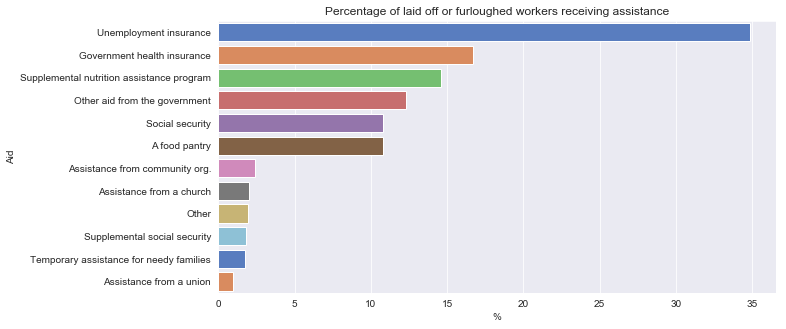

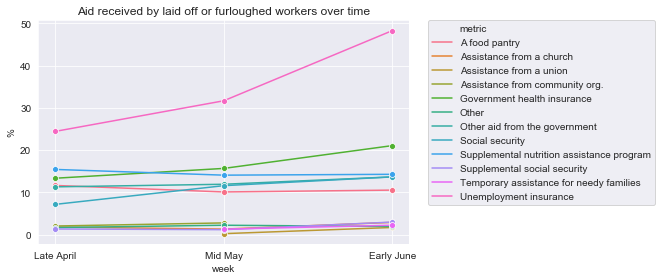

In [26]:
cols_aid = list(df.filter(regex='^a_').columns)
df_temp = df_furloughed[cols_aid + cols_weight + ['su_id','week']]
df_furloughed_aid = df_temp.set_index(['su_id','week', 'national_weight'])\
                          .stack()\
                          .reset_index()\
                          .rename({'level_3':'variable',0:'value'},axis=1)

df_furloughed_aid = df_furloughed_aid.groupby(['week','variable','value'])\
                                         .agg({'national_weight':'sum'})\
                                         .reset_index()
df_furloughed_aid = pd.merge(df_furloughed_aid, df_nat_furloughed, how='left', left_on='week',right_on='week')
df_furloughed_aid['percentage'] = 100*df_furloughed_aid['national_weight']/df_furloughed_aid['total_national_weight']

df_furloughed_aid = df_furloughed_aid.rename({'variable':'metric'}, axis=1)
df_furloughed_aid['metric'] = df_furloughed_aid['metric'].map(map_title_aid)
df_furloughed_aid = df_furloughed_aid.loc[df_furloughed_aid['value'].isin(['(1) Received'])]
df_furloughed_aid = df_furloughed_aid.groupby(['metric','week'])['percentage'].sum().reset_index()

fig = plt.figure(figsize=(10,5))
g = sns.barplot(data=df_furloughed_aid.groupby('metric')['percentage'].mean().sort_values(ascending=False).reset_index(), 
                y='metric', 
                x='percentage', 
                palette='muted',
                ci=None)

g.set(title='Percentage of laid off or furloughed workers receiving assistance', ylabel='Aid', xlabel='%')
save_plot('furloughed', 'aid.jpg')
plt.show()


g = sns.lineplot(x='week', y="percentage", hue="metric",marker='o',
                data=df_furloughed_aid)
g.set_xticks(range(1,4))

g.set(title='Aid received by laid off or furloughed workers over time', xticklabels=['Late April', 'Mid May', 'Early June'], ylabel='%')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

save_plot('furloughed', 'aid_history.jpg')
plt.show()

### Aid for people who often/sometimes run out of food

In [29]:
df_famine = df.loc[(df['food_didnt_last'].isin(['(1) Often true','(2) Sometimes true']))]

df_nat_famine = df_famine.groupby(['week'])['national_weight'].sum().reset_index()
df_nat_famine = df_nat_famine.rename({'national_weight':'total_national_weight'}, axis=1)

df_famine_ratio = df_famine.groupby('week')['national_weight'].sum().to_frame().join(df_total_national_weight.set_index('week'))
df_famine_ratio['ratio'] = df_famine_ratio['national_weight']/df_famine_ratio['total_national_weight']
print("Percentage of people who often/sometimes run out of money")
df_famine_ratio['ratio'].mean() * 100
# df_t

Percentage of people who often/sometimes run out of money


21.559147273008406

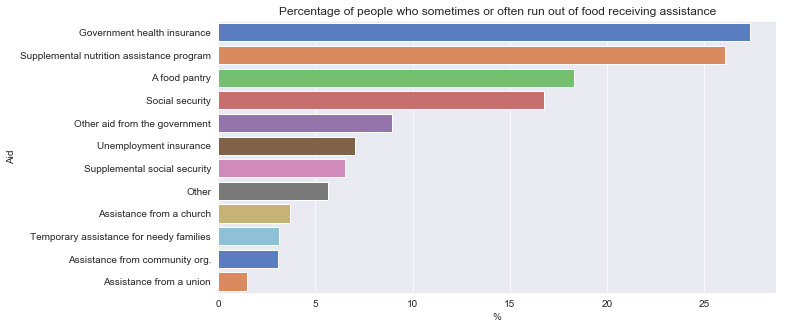

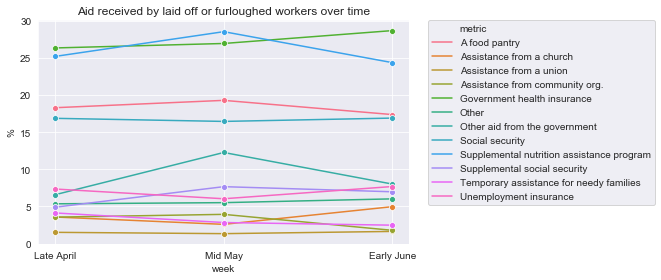

In [30]:
df_temp = df_famine[cols_aid + cols_weight + ['su_id','week']]
df_famine_aid = df_temp.set_index(['su_id','week', 'national_weight'])\
                          .stack()\
                          .reset_index()\
                          .rename({'level_3':'variable',0:'value'},axis=1)

df_famine_aid = df_famine_aid.groupby(['week','variable','value'])\
                                         .agg({'national_weight':'sum'})\
                                         .reset_index()
df_famine_aid = pd.merge(df_famine_aid, df_nat_famine, how='left', left_on='week',right_on='week')
df_famine_aid['percentage'] = 100*df_famine_aid['national_weight']/df_famine_aid['total_national_weight']

df_famine_aid = df_famine_aid.rename({'variable':'metric'}, axis=1)
df_famine_aid['metric'] = df_famine_aid['metric'].map(map_title_aid)
df_famine_aid = df_famine_aid.loc[df_famine_aid['value'].isin(['(1) Received'])]
df_famine_aid = df_famine_aid.groupby(['metric','week'])['percentage'].sum().reset_index()

fig = plt.figure(figsize=(10,5))
g = sns.barplot(data=df_famine_aid.groupby('metric')['percentage'].mean().sort_values(ascending=False).reset_index(), 
                y='metric', 
                x='percentage', 
                palette='muted',
                ci=None)

g.set(title='Percentage of people who sometimes or often run out of food receiving assistance', ylabel='Aid', xlabel='%')
save_plot('food', 'aid.jpg')
plt.show()

g = sns.lineplot(x='week', y="percentage", hue="metric",marker='o',
                data=df_famine_aid)
g.set_xticks(range(1,4))

g.set(title='Aid received by laid off or furloughed workers over time', xticklabels=['Late April', 'Mid May', 'Early June'], ylabel='%')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

save_plot('food', 'aid_history.jpg')
plt.show()

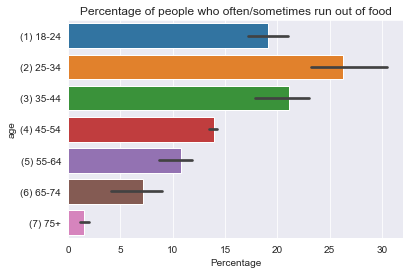

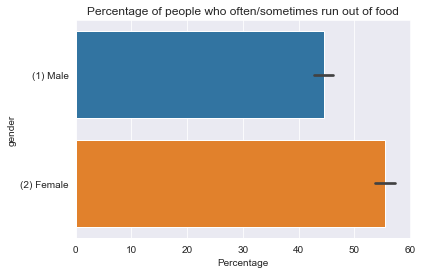

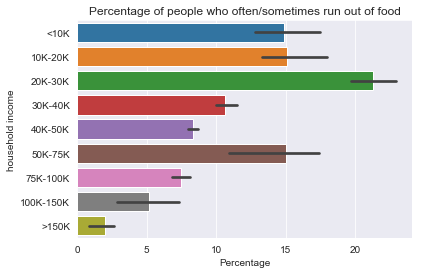

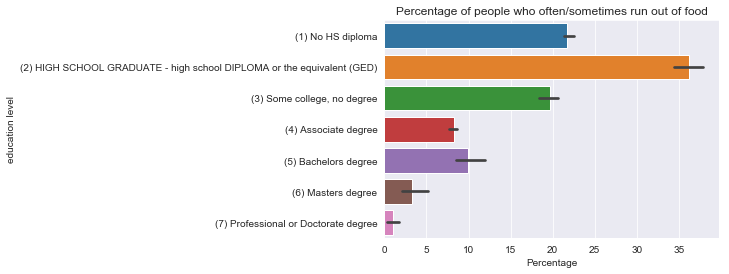

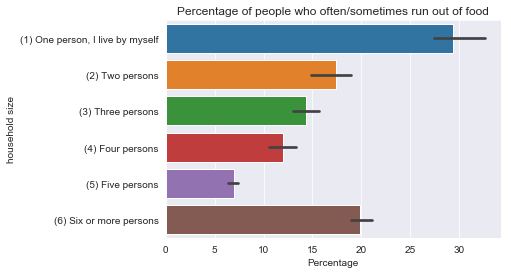

In [31]:
for demo in cols_demographic:
    if demo == 'su_id':
        continue

    df_temp = df_famine.groupby(['week',demo])['national_weight'].sum().reset_index()
    df_temp = pd.merge(df_temp, df_nat_famine, how='left', left_on=['week'], right_on=['week'])
    df_temp['percentage'] = df_temp['national_weight'] * 100 / df_temp['total_national_weight']
    df_temp = df_temp.reset_index()

    g = sns.barplot(data=df_temp, y=demo,x='percentage', order=hue_order[demo])
    g.set(ylabel=map_title_demographic[demo], xlabel='Percentage', title='Percentage of people who often/sometimes run out of food')
    plt.show()


# Precaution

In [32]:
# some variables for visualization
map_title_precaution={
     'prec_canceled_doctor_app': 'Canceled a doctor appointment',
     'prec_mask' : 'Worn a face mask',
     'prec_visit_doct': 'Visited a doctor or hospital',
     'prec_x_work': 'Canceled/postponed work act.',
     'prec_x_school': 'Canceled/postponed school act.',
     'prec_x_dentist': 'Canceled a dentist/other appointment',
     'prec_x_housekeeper': 'Canceled outside housekeepers or caregivers',
     'prec_avoid_restaurants': 'Avoided restaurants',
     'prec_telework': 'Worked from home',
     'prec_telestudy': 'Studied from home',
     'prec_x_recre_act': 'Canceled/postponed recreational act.',
     'prec_stockpiled': 'Stockpiled food or water',
     'prec_avoid_crowd': 'Avoided crowded places',
     'prec_prayed': 'Prayed',
     'prec_avoid_high_risk': 'Avoided contact w/ high-risk people',
     'prec_wash_hands': 'Washed hands',
     'prec_six_feet': 'Kept 6-ft distance',
     'prec_stay_home': 'Stayed home when unwell',
     'prec_wipe_packages': 'Wiped packages'
}

In [33]:
# calculate the percentage of people who take each covid precaution
cols_precaution = list(df.filter(regex='^prec_').columns)
df_precaution = df[cols_precaution + ['week'] + cols_weight].copy()

for col in cols_precaution:
    df_precaution[col] = pd.Series(df_precaution[col] == '(1) Yes').astype(int)

df_precaution_agg = df_precaution.groupby('week')[cols_precaution].sum().reset_index()
df_precaution_agg = pd.merge(df_precaution_agg, df_total_national_weight, how='inner', left_on='week', right_on='week')
for col in cols_precaution:
    df_precaution_agg[col] = df_precaution_agg[col] * 100 /df_precaution_agg['total_national_weight']

df_precaution_agg = df_precaution_agg.set_index('week').drop('total_national_weight', axis=1)
df_precaution_agg = df_precaution_agg.stack().reset_index().rename({'level_1':'metric', 0:'percentage'}, axis=1)

df_precaution_agg = df_precaution_agg.sort_values(by='percentage', ascending=False)
df_precaution_agg['metric'] = df_precaution_agg['metric'].map(map_title_precaution)
df_precaution_agg.head()

,week,metric,percentage
15,1,Washed hands,93.013699
34,2,Washed hands,91.286863
53,3,Washed hands,89.301417
39,3,Worn a face mask,88.666341
16,1,Kept 6-ft distance,87.351598


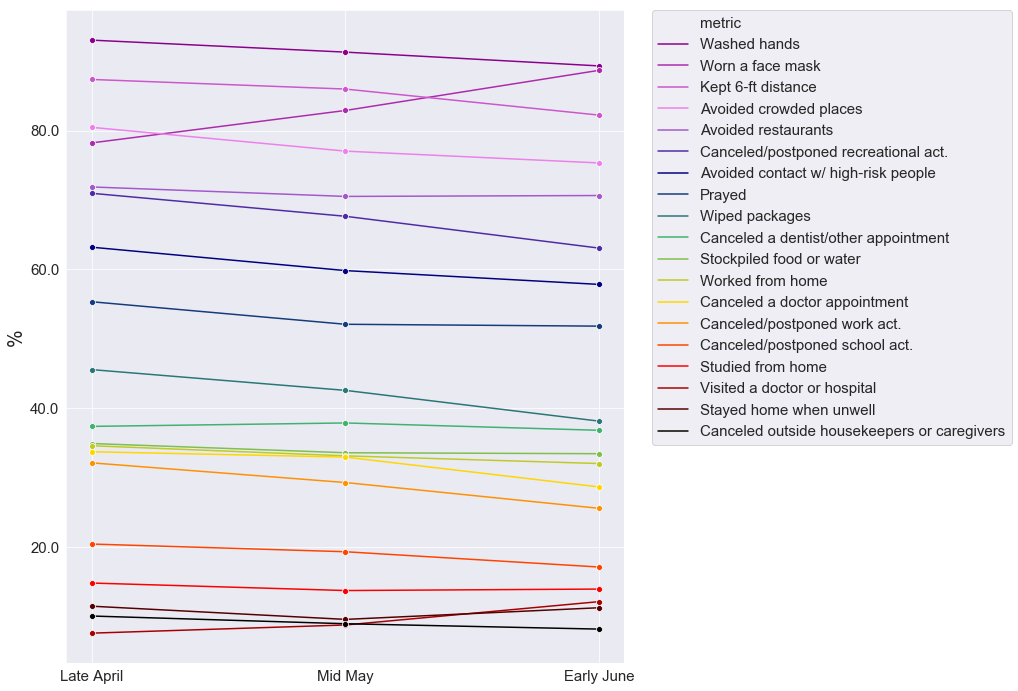

In [34]:
# visualize the precautions percentage by week
custom_palette = sns.color_palette("cubehelix", len(cols_precaution))
cmap = sns.blend_palette(["darkmagenta","violet","navy","mediumseagreen","gold", "red", "black"], len(cols_precaution)) 

fig = plt.figure(figsize=(10,12))
g = sns.lineplot(x='week', 
                 y="percentage", 
                 hue="metric",
                 marker='o',
                 data=df_precaution_agg,
                 palette=cmap)
g.set_xticks(range(1,4))
df_precaution_agg
g.set_yticklabels(g.get_yticks(), size = 15)
g.set_xticklabels(['Late April', 'Mid May', 'Early June'], size = 15)
g.set_ylabel("%",fontsize=20)
g.set_xlabel("")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})

save_plot("precaution","over_time.jpg")
plt.show()

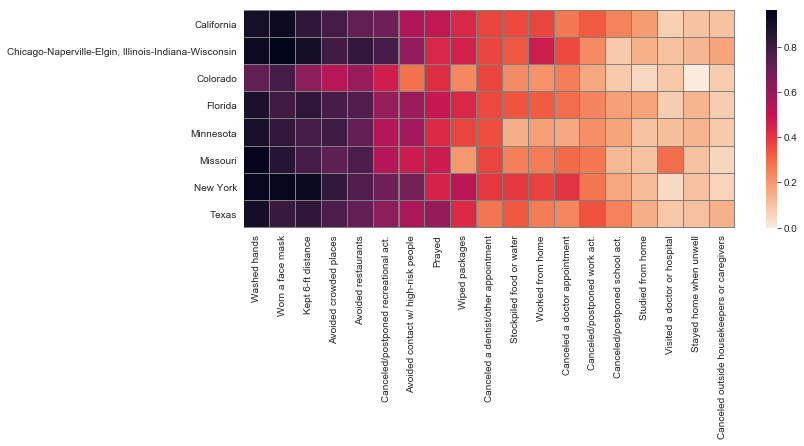

In [35]:
# visualize how people in different states are taking the precautions
df_temp = df[['p_geo'] + cols_stats + cols_precaution].copy()

for col in cols_precaution:
    df_temp[col] = pd.Series(df[col] == '(1) Yes').astype(int) * df_temp['national_weight']
    
l = df_temp.groupby(['week','p_geo'])[cols_precaution + ['national_weight']].sum().reset_index()
l[cols_precaution] = l[cols_precaution].div(l['national_weight'], axis=0)
l = l.groupby('p_geo')[cols_precaution].mean()#.reset_index()
l = l.rename(map_title_precaution,axis=1)
sns.set_style('darkgrid')
# Set up the matplotlib figure
fig = plt.figure(figsize=(11, 4))

# Generate a custom diverging colormap
cmap = sns.color_palette("Blues")#sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.cm.rocket_r
l = l[df_precaution_agg['metric'].unique()]
# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(l,cmap=cmap, linewidths=0.05,linecolor='grey')
g.set_ylabel('')
# plt.tight_layout()
save_plot('precaution','geo.jpg')
plt.show()